# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [173]:
!pip install pycairo --user
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time
import math
import cairo
from scipy import ndimage

# modify to where you store your project data including utils.py
#datadir = "/content/drive/My Drive/cs445_projects/proj2/" 

#utilfn = datadir + "utils.py"
#!cp "$utilfn" .
#samplesfn = datadir + "samples"
#!cp -r "$samplesfn" .
import utils

You are using pip version 10.0.1, however version 21.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [161]:
from utils import cut # default cut function for seam finding section

In [324]:
def paint(source_im):
    #canvas = np.zeros((source_im.shape[0], source_im.shape[1], 3), np.uint8)
    canvas = cairo.ImageSurface(cairo.FORMAT_RGB24, source_im.shape[0], source_im.shape[1])
    context = cairo.Context(canvas)
    context.scale(source_im.shape[0], source_im.shape[1])
    context.set_line_cap(cairo.LINE_CAP_ROUND)
        
    brushes = [16, 8]
    
    # paint the canvas
    for brush in brushes:
        # apply Gaussian blur
        reference_im = cv2.GaussianBlur(source_im, (5, 5), 0)
        
        # paint a layer
        paint_layer(canvas, reference_im, brush, context)
        
    return canvas   
    

In [325]:
def paint_layer(canvas, reference_im, brush, context):
    # set of strokes
    S = []
    
    # create a pointwise difference image
    canvas_array = np.array(canvas.get_data())
    canvas_array = canvas_array.reshape(canvas.get_height(), canvas.get_width(), 4)
    canvas_array = np.dstack((canvas_array[:, :, 2], canvas_array[:, :, 1], canvas_array[:, :, 0]))
    canvas_array = canvas_array.astype(dtype=np.int32)
    canvas_array = canvas_array.swapaxes(0,1)
    
    delta = canvas_array - reference_im
    D = np.sqrt(np.sum(delta**2, axis=-1))
    
    grid = brush
    
    width = canvas.get_width()//grid * grid
    height = canvas.get_height()//grid * grid
    
    for x in range(0, width, grid):
        for y in range(0, height, grid):
            # sum the error near (x, y)
            M = D[x:x+grid, y:y+grid]
            area_error = M.sum()/(grid * grid)
            if area_error > 10:
                x_1, y_1 = np.unravel_index(np.argmax(M), M.shape)
                s = make_stroke(brush, x+x_1, y+y_1, reference_im, canvas_array)
                S.append(s)
                                
    random.shuffle(S)
    
    for s in S:
        context.set_line_width(max(context.device_to_user_distance(2 * brush, 2 * brush)))
        stroke_color = reference_im[s[0]]/255
        context.set_source_rgb(stroke_color[0], stroke_color[1], stroke_color[2])

        context.move_to(s[0][0] / canvas.get_width(), s[0][1] / canvas.get_height())
        for i in range(1, len(s)):
            context.line_to(s[i][0] / canvas.get_width(), s[i][1] / canvas.get_height())
            context.move_to(s[i][0] / canvas.get_width(), s[i][1] / canvas.get_height())

        context.close_path()
        context.stroke()

In [326]:
def make_stroke(radius, x0, y0, reference_im, canvas_array):
    stroke_color = reference_im[x0, y0,:]
    K = [(x0, y0)]
    x = x0
    y = y0
    lastDx = 0
    lastDy = 0
    
    ref_img = cv2.cvtColor(reference_im, cv2.COLOR_BGR2GRAY) /255.0
    gradient_x = ndimage.sobel(ref_img, 0)
    gradient_y = ndimage.sobel(ref_img, 1)
    
    for i in range(1,16+1):
        if x >= canvas.get_width() or y >= canvas.get_height():
            return K
        
        if i > 4 and np.linalg.norm(reference_im[x, y] - canvas_array[x, y]) < np.linalg.norm((reference_im[x, y] - stroke_color)):
            return K
        
        gx = gradient_x[x, y]
        gy = gradient_y[x, y]
        
        if (gx * gx + gy * gy) == 0:
            return K

        dx, dy = -gy, gx

        if lastDx * dx + lastDy * dy < 0:
            dx = -dx
            dy = -dy

        dx = 1 * dx + (1 - 1) * lastDx
        dy = 1 * dy + (1 - 1) * lastDy
        x = x + radius * dx / np.sqrt(dx * dx + dy * dy)
        y = y + radius * dx / np.sqrt(dx * dx + dy * dy)

        x = int(round(x))
        y = int(round(y))

        if 0>x>=canvas.get_width() or 0>y>=canvas.get_height():
            return K

        lastDx = dx / np.sqrt(dx * dx + dy * dy)
        lastDy = dy / np.sqrt(dx * dx + dy * dy)

        K.append((x,y))

    return K

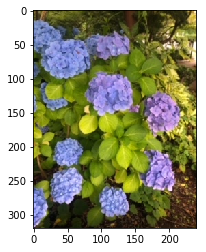

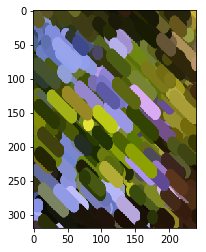

In [327]:
sample_img_fn = 'samples/hydrangea.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

canvas = paint(sample_img)
canvas_array = np.array(canvas.get_data())
canvas_array = canvas_array.reshape(canvas.get_height(), canvas.get_width(), 4)
canvas_array = np.dstack((canvas_array[:, :, 2], canvas_array[:, :, 1], canvas_array[:, :, 0]))
canvas_array = canvas_array.astype(dtype=np.int32)
canvas_array = canvas_array.swapaxes(0,1)
if canvas_array is not None:
    plt.imshow(canvas_array)